<a href="https://colab.research.google.com/github/ChecinskiBartlomiej/UM/blob/main/UM_hw_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: EM Clustering in 2D**
-------------------------------

You have seen how the **Expectation-Maximization (EM)** algorithm can fit a Gaussian Mixture Model (GMM) to a 2D dataset. You should now explore:

## **Primary Question**

**How can we visualize the *decision boundary* for attributing a *new* (unlabeled) point to one of the GMM clusters?**  

In other words, given a 2D data distribution modeled by EM, think of a way to clearly show (on a plot) *which* cluster a point would be assigned to (or which cluster has the highest responsibility (posterior probability) for that point)?  

The plot should comprehensively cover the entire visible region, ensuring that for any point on the plot, it is immediately evident which cluster it would belong to. You can plot **lines** separating clusters or use a **color map** showing each point's "most likely cluster".

You can illustrate your approach with **the same** 2D dataset that we used in class, or you can find another suitable 2D dataset, it's up to you. Note however, that having 3 clusters enhances the clarity of the visualization—while 2 clusters result in overly simple boundaries, using 4 or more clusters can make the entire plot difficult to interpret. Try to choose a dataset with 3 clusters.

Discuss any irregularities observed in the resulting plot. If a decision boundary suggests that a region should be attributed to a cluster in a counterintuitive way (we saw it in class!), provide an explanation for why this might occur. It may be also an indication you have a bug in your code.

## **Secondary Question**

**If we *didn't know* the number of clusters in advance, how could we decide on a suitable $K$ for the clustering algorithm?**  

You can illustrate your approach with **the same** dataset as in the primary question by trying different values of $K$ (and optionally plotting the evaluation metric values, e.g. silhouette scores, etc.). Or you can find another suitable dataset, it's up to you. Note, that the dataset doesn't need to be 2D in this task.

## **Task & Deliverables**

1. **Colab Notebook**  
   - Create a **Colab notebook** that:
     - Clearly **answers** both the **primary** and **secondary** questions with appropriate plots and short explanations.
     - Uses Python code (e.g. `scikit-learn` for GMM) to visualize:
       1. The **data** and **cluster assignments**.
       2. The **decision boundary** (lines or a color map) indicating each cluster's region.
       3. A demonstration (chart or table) of how you would pick a suitable number of clusters $K$ when it is not known.
   - Remember to use the `$` symbol to delimit **inline equations** and `$$` to delimit **full-line equations**.

2. **Publish on GitHub**  
   - Place the Colab notebook in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.



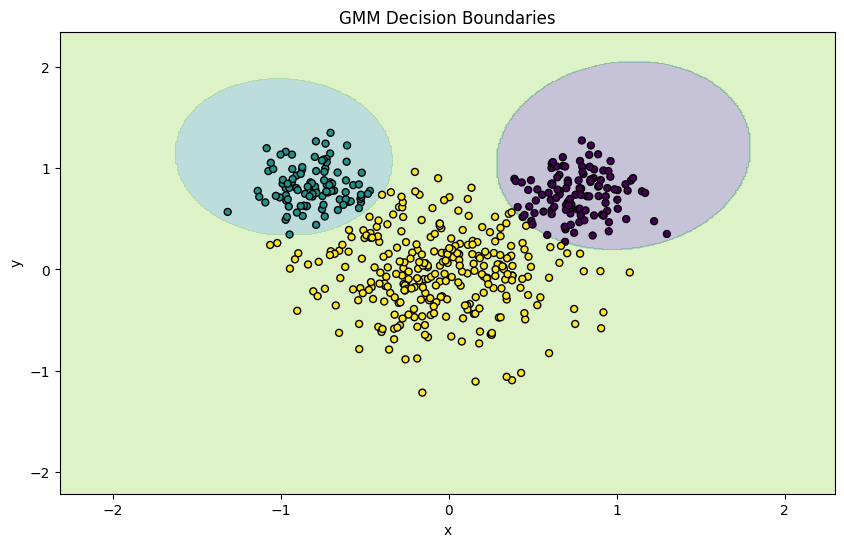

In [1]:
import numpy as np

# Generate the "mouse" dataset
np.random.seed(0)  # for reproducibility

# 1) 300 points from N([0, 0], [[0.16, 0],[0, 0.16]])
mean1 = np.array([0.0, 0.0])
cov1 = np.array([[0.16, 0.0],
                 [0.0,  0.16]])
data1 = np.random.multivariate_normal(mean1, cov1, 300)

# 2) 100 points from N([0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean2 = np.array([0.8, 0.8])
cov2 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data2 = np.random.multivariate_normal(mean2, cov2, 100)

# 3) 100 points from N([-0.8, 0.8], [[0.04, 0],[0, 0.04]])
mean3 = np.array([-0.8, 0.8])
cov3 = np.array([[0.04, 0.0],
                 [0.0,  0.04]])
data3 = np.random.multivariate_normal(mean3, cov3, 100)

# Combine all data
X = np.vstack([data1, data2, data3])
N, d = X.shape  # should be (500, 2)

# Fit a Gaussian Mixture Model with 3 components.
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X)
labels = gmm.predict(X)

# Create a dense grid of points covering the region of the data.
x = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 500)
y = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 500)
xx, yy = np.meshgrid(x, y)
grid = np.c_[xx.ravel(), yy.ravel()]

# Compute the responsibilities (posterior probabilities) for each grid point.
resp = gmm.predict_proba(grid)
# Determine the cluster assignment by selecting the component with the highest responsibility.
cluster_grid = np.argmax(resp, axis=1).reshape(xx.shape)

# Plot the decision boundaries using a filled contour plot.
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, cluster_grid, alpha=0.3, levels=np.arange(4)-0.5, cmap='viridis')
plt.scatter(X[:, 0], X[:, 1],c = labels, s=25, edgecolor='k')
plt.title("GMM Decision Boundaries")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

This is interesting. Look at the extreme points, particularly in the upper left and right corners. Naively, one might think that a point should be assigned to the cluster whose center is closest to it—as is done in the K-means algorithm. However, in the EM algorithm, points are assigned based on responsibilities, which are defined as:

$$
r_{ik} = P(z_k = 1 \mid x_i) \;=\; \frac{\pi_k \,\mathcal{N}\bigl(x_i \mid \mu_k, \Sigma_k\bigr)}{\sum_{j=1}^K \pi_j \,\mathcal{N}\bigl(x_i \mid \mu_j, \Sigma_j\bigr)}
$$

Note that while the denominator acts as a normalizing constant (and does not affect which cluster has the highest responsibility), both the mixture weight $\pi_k$ and the density $\mathcal{N}(x_i \mid \mu_k, \Sigma_k)$ are crucial. They capture not only the distance of the point $x_i$ from the cluster center $\mu_k$ but also the shape and size of the cluster as determined by $\Sigma_k$. As a result, the point is assigned to the cluster for which the responsibility $r_{ik}$ is the highest.







When choosing the number of clusters, we will focus on BIC, AIC, and Silhouette Scores. AIC and BIC provide a means for model selection by quantifying both the goodness of fit and the simplicity of the model. Lower values indicate better model. We discussed the Silhouette Score previously. We will compare models with different numbers of clusters.

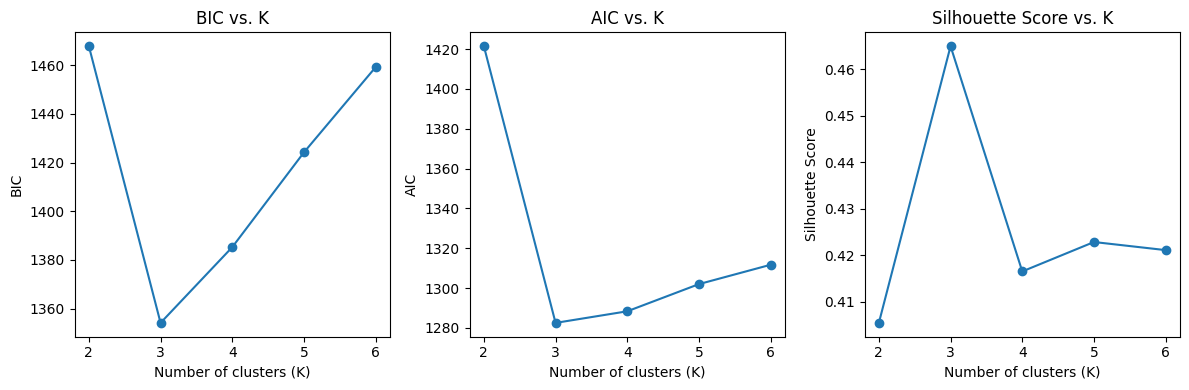

In [2]:
from sklearn.metrics import silhouette_score
bic_scores = []
aic_scores = []
silhouette_scores = []
Ks = range(2, 7)  # testing for K = 2, 3, 4, 5, 6

for k in Ks:
    gmm_k = GaussianMixture(n_components=k, random_state=42)
    gmm_k.fit(X)
    bic_scores.append(gmm_k.bic(X))
    aic_scores.append(gmm_k.aic(X))
    labels = gmm_k.predict(X)
    sil_score = silhouette_score(X, labels)
    silhouette_scores.append(sil_score)

# Plot the evaluation metrics for different values of K.
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(Ks, bic_scores, marker='o')
plt.title("BIC vs. K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("BIC")

plt.subplot(1, 3, 2)
plt.plot(Ks, aic_scores, marker='o')
plt.title("AIC vs. K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("AIC")

plt.subplot(1, 3, 3)
plt.plot(Ks, silhouette_scores, marker='o')
plt.title("Silhouette Score vs. K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

As we can see every measure suggest that we should pick $K=3$.